# Dogs vs Cats | The quick way

WARNING : Put this file in the /courses/dl1 folder of your Fastai folder.

Original file : https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb

## Setup the Fastai library and the path to data

In [17]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [19]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

The dataset is available at http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. wget http://files.fast.ai/data/dogscats.zip. You should put the data in a subdirectory of this notebook's directory, called data/. Note that this data is already available in Crestle and the Paperspace fast.ai template.

In [27]:
# Put the path to your dogscats folder that corresponds to your installation
PATH = "data/dogscats/"
sz=224

In [28]:
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

## Check your path

In [29]:
os.listdir(PATH)

['models', 'sample', 'test1', 'tmp', 'train', 'valid']

In [30]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [31]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.1001.jpg',
 'cat.10016.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg']

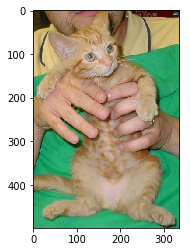

In [32]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

## Easy steps to train a world-class image classifier

### 1) Define your model

Fastai notes : Enable data augmentation, and precompute=True

In [7]:
# Uncomment the below if you need to reset your precomputed activations
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [8]:
# our model
arch=resnet34

In [9]:
# our data transformation
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [11]:
# CODE HERE of the data object using PATH and tfms (1 line)
# data = ...
# CODE HERE of the learn object using the pretrained model, the data object and precompute=True (1 line)
# learn = ...

### 2) Find the learning rate

Fastai notes : Use lr_find() to find highest learning rate where loss is still clearly improving

In [12]:
# CODE HERE of the function to search for the best learning rate (1 line)

In [18]:
# CODE HERE of the function to plot the loss versus the learning rate (1 line)

### 3) Train quickly the last layer of your model 

Fastai notes : Train last layer from precomputed activations for 1-2 epochs

In [13]:
# CODE HERE for training the learn model with learning rate 1e-2 and 1 epoch (1 line)
# learn.fit(...)

### 4) Train the last layer of your model with data augmentation and SGDR

Fastai notes : Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1

In [14]:
# CODE HERE for setting the learn model to precompute=False (1 line)

In [15]:
# CODE HERE for training the learn model with learning rate 1e-2, 3 cycles and one learning rate restart by epoch (1 line)
# learn.fit(...)

In [22]:
# CODE HERE for saving your model (the values of the parameters/weights) to 224_lastlayer (1 line)

### 5) Allow the layers of the pretrained model to be trained

Fastai notes : Unfreeze all layers

In [ ]:
# CODE HERE for loading your model (the values of the parameters/weights) from 224_lastlayer (1 line)

In [24]:
# CODE HERE for unfreezing the first layers of the model (1 line)

### 6) Get 1 learning rate by group of layers (diferential learning rate)

Fastai notes : Set earlier layers to 3x-10x lower learning rate than next higher layer

In [12]:
# CODE HERE of the function to search for the best learning rate (1 line)

In [18]:
# CODE HERE of the function to plot the loss versus the learning rate (1 line)

In [ ]:
# CODE HERE for setting the lr variable to an array of 3 learning rates (1 line)
# lr = ...

In [16]:
# CODE HERE for training the learn model with the diferential learning rate, 3 cycles, one learning rate restart by epoch
# and double the length of a cycle after each cycle (1 line)
# learn.fit(...)

In [ ]:
# CODE HERE for saving your model (the values of the parameters/weights) to 224_all (1 line)

### 7) Get the validation accuracy by using TTA

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
accuracy_np(probs, y)

## Analyzing results | Confusion matrix 

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

In [ ]:
plot_confusion_matrix(cm, data.classes)